# __Movie Ratings Analysis using LSTM__

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy
import seaborn as sb
import tensorflow as tf

from tensorflow import keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from nltk.corpus import words
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [2]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [5]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [6]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 'adult',
               'overview', 'tagline', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,127.0,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [7]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [8]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [9]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [10]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,170.0,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,127.0,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,106.0,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [11]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,rw0213367,SUPERNOVA HEIGHTS,A Nightmare on Elm Street (1984),8.0,A Classic of the horror films History,27 August 2003,0,This is the beginning of a great horror film s...,"['0', '0']",Positive
1,rw0213369,kibler@adelphia.net,A Nightmare on Elm Street (1984),NaN,Better than your average horror movie,1 September 2003,0,"Nightmare on Elm Street, A (1984) John Saxon, ...","['0', '0']",Negative
2,rw0213371,matthew87,A Nightmare on Elm Street (1984),NaN,good slasher flick,1 September 2003,0,"the best freddy film period,1 because the horr...","['0', '0']",Strongly Positive
3,rw0213375,rossrobinson,A Nightmare on Elm Street (1984),10.0,A nightmare on elm st part 1,27 September 2003,0,I remember seeing a nightmare on elm street pa...,"['0', '2']",Negative
4,rw0213376,Andres24,A Nightmare on Elm Street (1984),9.0,Highway to hell,3 October 2003,0,"It's a nightmare. If Nancy falls asleep, they...","['1', '1']",Positive


In [12]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,88846,Brazil (1985),Drama;Sci-Fi,rw0218839,movieman-138,1.0,"horrible , so overrated ...",10 April 2001,0,The best thing about this movie is the cover. ...,"['13', '32']",Negative
1,88846,Brazil (1985),Drama;Sci-Fi,rw0218845,Klickberg,NaN,"Influential, shocking, superb",3 June 2001,0,"I have tried to watch ""Brazil"" all the way thr...","['0', '0']",Positive
2,88846,Brazil (1985),Drama;Sci-Fi,rw0218850,bedazzle,8.0,brazil vs 1984,17 July 2001,1,"Interpretation, spoilers:There are two main di...","['0', '0']",Negative
3,88846,Brazil (1985),Drama;Sci-Fi,rw0218851,rogierr,NaN,Where would we be if we didn't stick to the co...,19 July 2001,0,A little bit of sand in the system (or a beetl...,"['0', '0']",Positive
4,88846,Brazil (1985),Drama;Sci-Fi,rw0218856,watto124,10.0,Mr. Gilliam's brilliant opus.,28 August 2001,0,Terry Gilliam will most likely ever make a bet...,"['0', '1']",Strongly Positive


In [13]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_date,review_detail,roberta_sentiment
0,88846,1.0,"horrible , so overrated ...",10 April 2001,The best thing about this movie is the cover. ...,Negative
1,88846,NaN,"Influential, shocking, superb",3 June 2001,"I have tried to watch ""Brazil"" all the way thr...",Positive
2,88846,8.0,brazil vs 1984,17 July 2001,"Interpretation, spoilers:There are two main di...",Negative
3,88846,NaN,Where would we be if we didn't stick to the co...,19 July 2001,A little bit of sand in the system (or a beetl...,Positive
4,88846,10.0,Mr. Gilliam's brilliant opus.,28 August 2001,Terry Gilliam will most likely ever make a bet...,Strongly Positive


## Exploratory Data Analysis

Check and resolve duplicate records

In [14]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [15]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 1202
Record count after removing duplicates  => 1202


Check and resolve missing values for `movie metadata`

In [16]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
runtime                 3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [17]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
2780,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [18]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4068 non-null   float64
 1   genres                4068 non-null   object 
 2   imdb_id               4068 non-null   int64  
 3   production_companies  4068 non-null   object 
 4   release_date          4068 non-null   object 
 5   revenue               4068 non-null   float64
 6   runtime               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   cast                  4068 non-null   object 
 9   crew                  4068 non-null   object 
 10  movie                 4068 non-null   object 
 11  genre                 4068 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 413.2+ KB


Check and resolve missing values for `movie reviews`

In [19]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id                0
rating               461
review_summary         0
review_date            0
review_detail          0
roberta_sentiment      0
dtype: int64

In [20]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 0 to 1201
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            1202 non-null   int64  
 1   rating             741 non-null    float64
 2   review_summary     1202 non-null   object 
 3   review_date        1202 non-null   object 
 4   review_detail      1202 non-null   object 
 5   roberta_sentiment  1202 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 65.7+ KB


In [21]:
# Define a mapping for sentiment to rating
sentiment_to_rating = {
    'Strongly Positive' : 1,
    'Positive': 8,
    'Neutral': 5,
    'Negative': 2,
    'Strongly Negative': 10
}

# Fill null values in the 'rating' column based on the 'sentiment' column
movie_reviews_df['rating'].fillna(movie_reviews_df['roberta_sentiment'].map(sentiment_to_rating), inplace=True)

# Convert the ratings to integer type
movie_reviews_df['rating'] = movie_reviews_df['rating'].astype(int)
movie_reviews_df['rating'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1202 entries, 0 to 1201
Series name: rating
Non-Null Count  Dtype
--------------  -----
1202 non-null   int32
dtypes: int32(1)
memory usage: 14.1 KB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [22]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'movie', 'release_year', 'genre', 'runtime', 'budget', 'revenue', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,movie,release_year,genre,runtime,budget,revenue,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,81.0,30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,104.0,65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,170.0,60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,127.0,58000000.0,0.0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,106.0,35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [23]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Looking at the movies available on Netflix, Disney+, and Amazon Prime Video, they only have movies from the 1930s onwards. So, we're going to remove any movies made before 1930.

In [24]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['release_year'] >= 1930]

Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [25]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)

movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year
0,88846,1,"horrible , so overrated ...",The best thing about this movie is the cover. ...,Negative,2001
1,88846,8,"Influential, shocking, superb","I have tried to watch ""Brazil"" all the way thr...",Positive,2001
2,88846,8,brazil vs 1984,"Interpretation, spoilers:There are two main di...",Negative,2001
3,88846,8,Where would we be if we didn't stick to the co...,A little bit of sand in the system (or a beetl...,Positive,2001
4,88846,10,Mr. Gilliam's brilliant opus.,Terry Gilliam will most likely ever make a bet...,Strongly Positive,2001


In [26]:
# Combine 'positive' and 'strongly positive' reviews, and 'negative' and 'strongly negative' reciews
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Positive', 'Positive')
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Negative', 'Negative')
movie_reviews_df['roberta_sentiment'].value_counts().unique

<bound method Series.unique of Positive    790
Neutral     227
Negative    185
Name: roberta_sentiment, dtype: int64>

Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [27]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,runtime,budget,revenue,rating,review_year
count,1202.000000,1202.000000,1202.000000,1.202000e+03,1.202000e+03,1202.000000,1202.000000
mean,88348.094842,1984.341930,109.324459,9.144727e+06,7.390612e+07,6.717138,2001.471714
std,349.381062,0.474554,29.178075,8.824468e+06,1.131154e+08,3.136610,1.694763
min,87800.000000,1984.000000,79.000000,0.000000e+00,0.000000e+00,1.000000,1998.000000
25%,88117.000000,1984.000000,93.000000,1.800000e+06,4.736202e+06,5.000000,2000.000000
50%,88247.000000,1984.000000,106.000000,6.400000e+06,3.837650e+07,8.000000,2002.000000
75%,88763.000000,1985.000000,116.000000,1.500000e+07,7.837120e+07,9.000000,2003.000000
max,88930.000000,1985.000000,229.000000,3.500000e+07,3.811098e+08,10.000000,2004.000000


Tally the number of reviews categorized by customer ratings ranging from 1 (lowest) to 10 (highest) to gauge the overall sentiment of the dataset based on these ratings. Get the frequency for each review sentiment as well, which was based from RoBERTa.

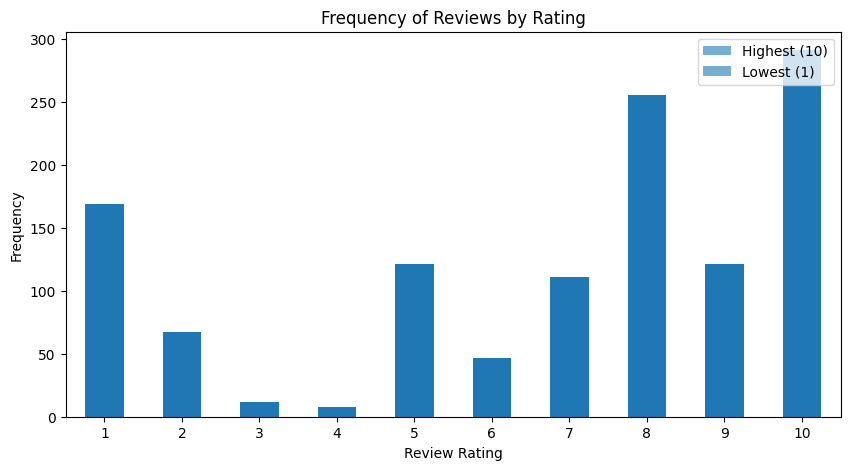

In [28]:
# Count the reviews based on customer ratings
rating_counts = movie_reviews_df['rating'].value_counts().sort_index()
ax = rating_counts.plot(kind='bar', title='Frequency of Reviews by Rating', figsize=(10, 5))

ax.set_xlabel('Review Rating')
ax.set_ylabel('Frequency')

# Add a custom legend indicating 10 as highest and 1 as lowest
legend_labels = {10: 'Highest (10)', 1: 'Lowest (1)'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, alpha=0.6, label=label) for rating, label in legend_labels.items()]

ax.legend(handles=legend_handles, labels=legend_labels.values(), loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

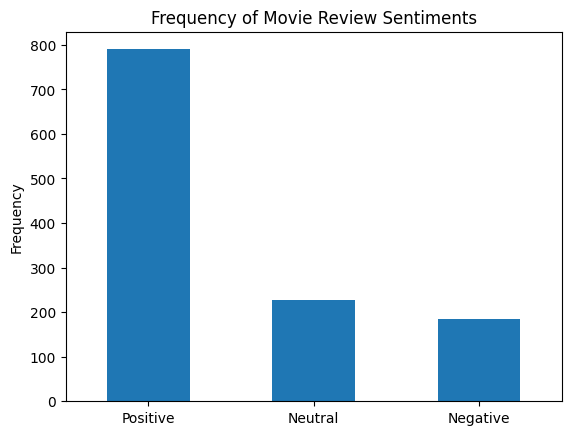

In [29]:
# Get the frequency of values in the 'roberta_sentiment' column
sentiment_counts = movie_reviews_df['roberta_sentiment'].value_counts()
sentiment_counts.plot(kind='bar')

plt.ylabel('Frequency')
plt.title('Frequency of Movie Review Sentiments')
plt.xticks(rotation=0)
plt.show()

#### __For Text Pre-processing__:

__The movie summary and reviews undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [30]:
emoji_dict = tp.get_emojis()
slang_word_dict = tp.get_slang_words(webscraped=False)

def conduct_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)

        # Replace non-ascii characters as there are Python libraries limiting this feature
        text = tp.replace_nonascii_characters(text)

        # Replace HTML characters
        text = tp.replace_html_char(text)

        # Replace emojis with English word/s
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

        # Remove leading and trailing whitespaces
        text = text.strip()

        # Replace multiple whitespaces with a single space
        text = tp.replace_whitespace(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(conduct_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary:")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details:")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
horrible , so overrated ...

Cleaned Review Summary:
horrible , so overrated ...
Original Review Summary:
Influential, shocking, superb

Cleaned Review Summary:
Influential, shocking, superb
Original Review Summary:
brazil vs 1984

Cleaned Review Summary:
brazil vs 1984
Original Review Summary:
Where would we be if we didn't stick to the correct procedures?

Cleaned Review Summary:
Where would we be if we did not stick to the correct procedures?
Original Review Summary:
Mr. Gilliam's brilliant opus.

Cleaned Review Summary:
Mr. Gilliam's brilliant opus.
Original Review Details:
The best thing about this movie is the cover. Other than that, this is a total waste of time. Seeing this movie number 154 on the top 250 I was looking forward on watching this thinking it would be similar to the princess bride or something somewhat werid but entertaining. This movie is just a joke. I rather see remember the titans(yuck). FINAL VERDICT 1 out of 10 . I have to give it tha

In [31]:
# Drop the old reviews and detail, replacing them with the pre-processed one
movie_reviews_df['review_summary'] = movie_reviews_df['cleaned_review_summary']
movie_reviews_df['review_detail'] = movie_reviews_df['cleaned_review_detail']

movie_reviews_df = movie_reviews_df.drop(columns=['cleaned_review_summary', 'cleaned_review_detail'], axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year
0,88846,1,"horrible , so overrated ...",The best thing about this movie is the cover. ...,Negative,2001
1,88846,8,"Influential, shocking, superb","I have tried to watch ""Brazil"" all the way thr...",Positive,2001
2,88846,8,brazil vs 1984,"Interpretation, spoilers:There are two main di...",Negative,2001
3,88846,8,Where would we be if we did not stick to the c...,A little bit of sand in the system (or a beetl...,Positive,2001
4,88846,10,Mr. Gilliam's brilliant opus.,Terry Gilliam will most likely ever make a bet...,Positive,2001


Generate word clouds the can help to visualize the most frequent words in the review_details and review_summary columns

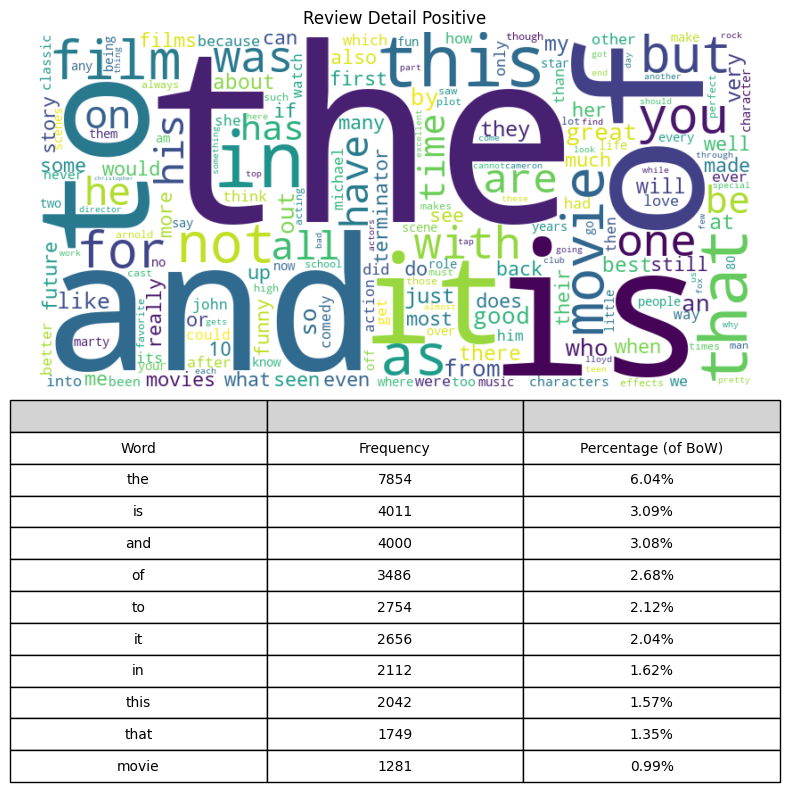

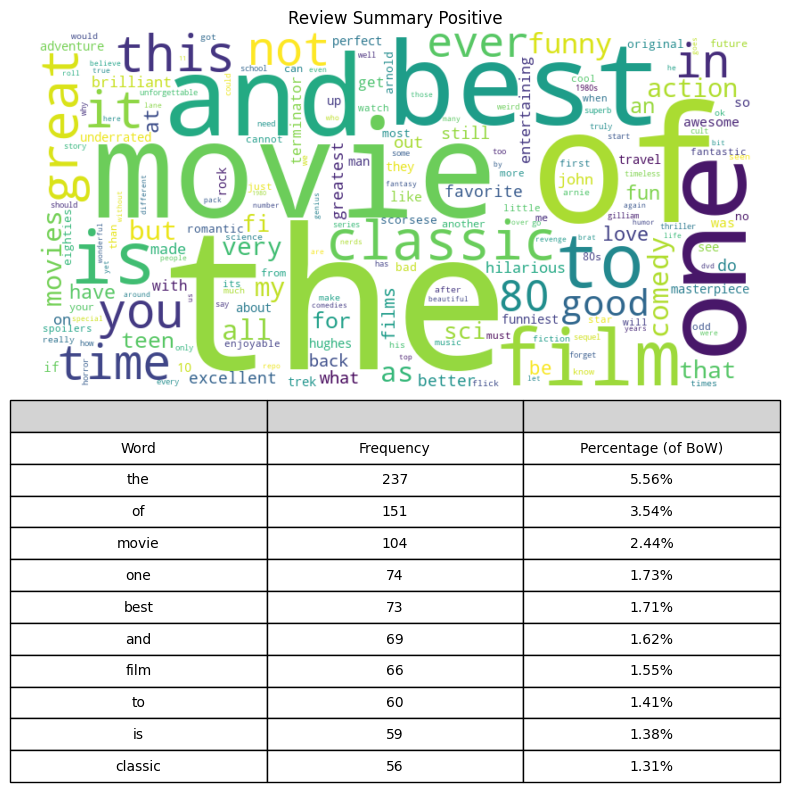

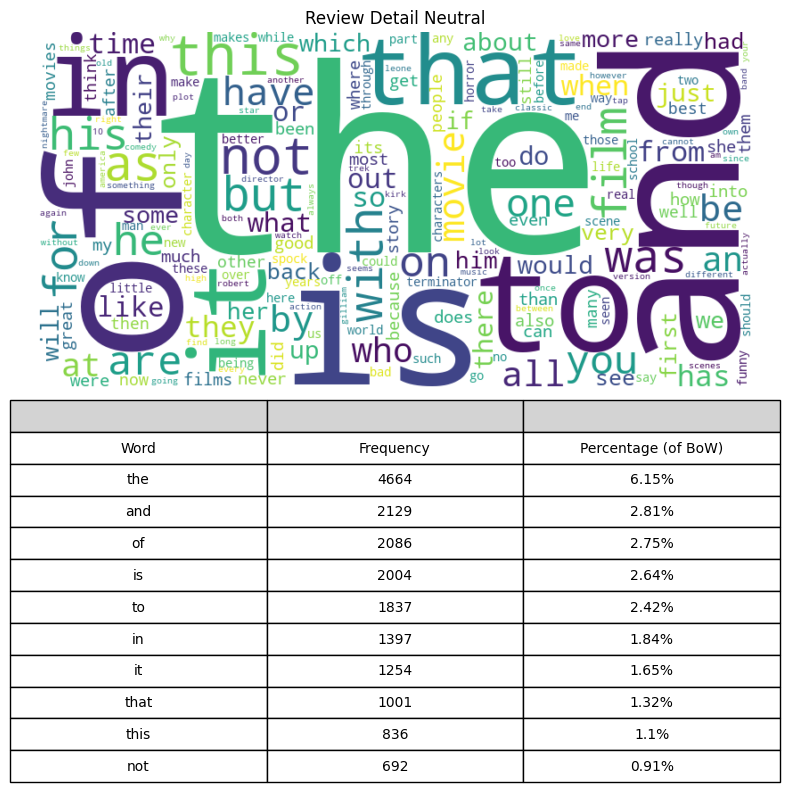

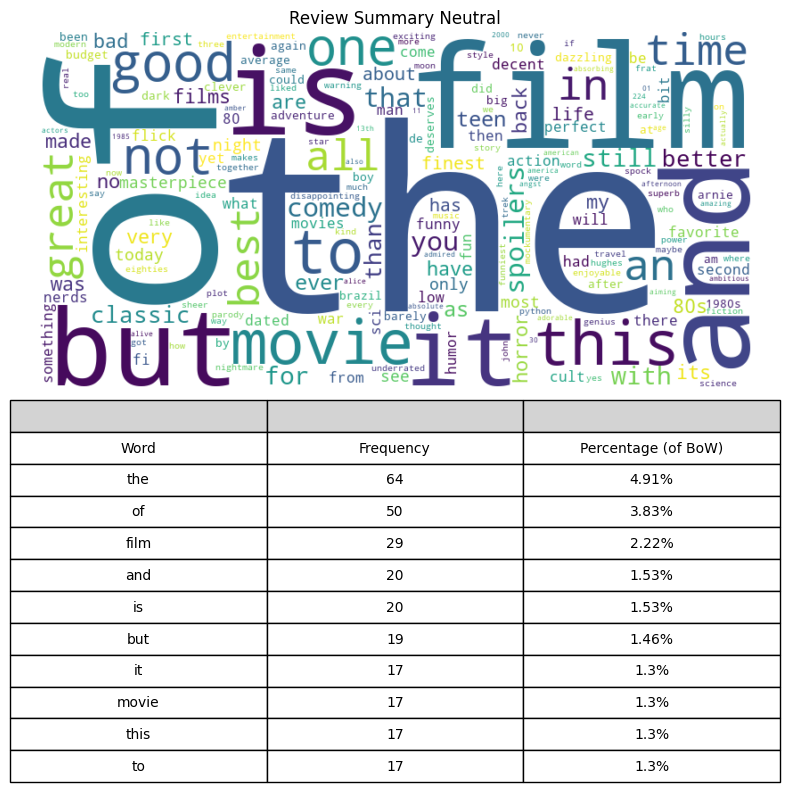

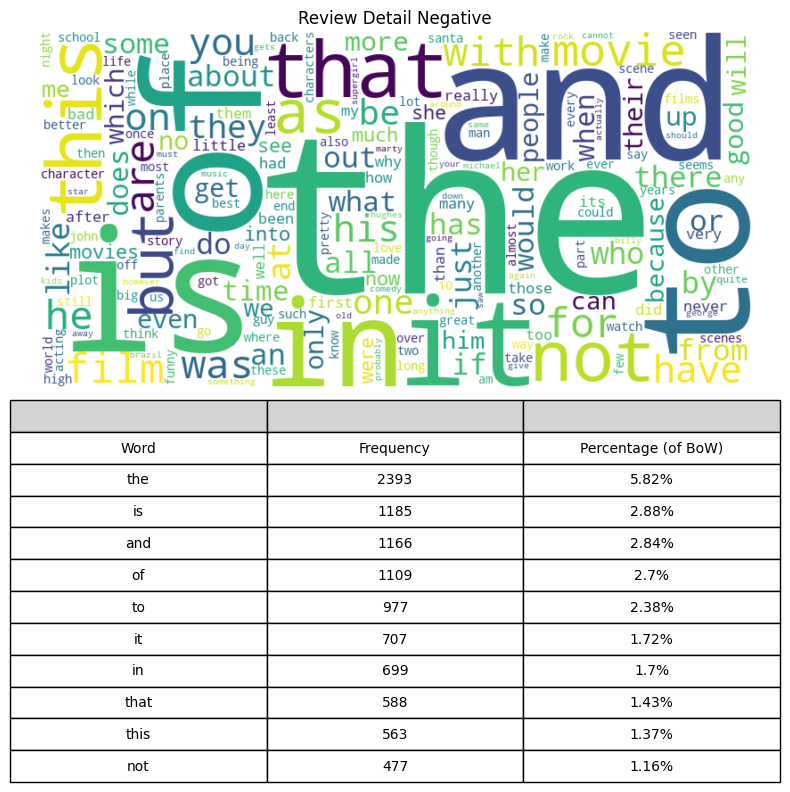

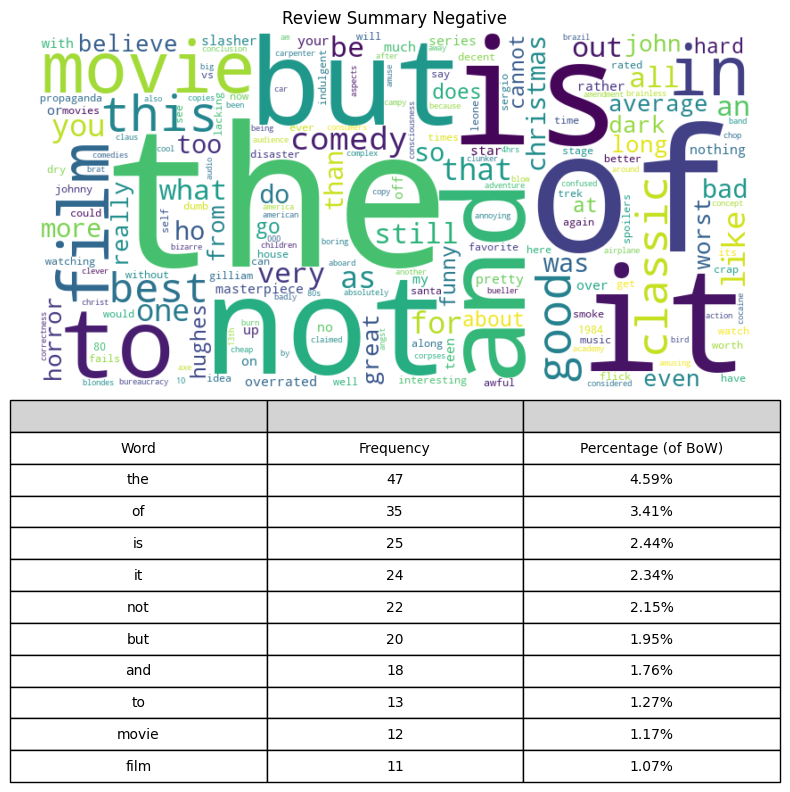

In [32]:
# Function to generate word cloud from BoW and display top 10 words with count and BoW percentage in a table
def generate_wordcloud_with_table(bow_matrix, title):
    feature_names = vectorizer.get_feature_names_out()
    word_freq = dict(zip(feature_names, bow_matrix.sum(axis=0).tolist()[0]))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Get total words in BoW
    total_words_bow = sum(word_freq.values())
    
    # Get top 10 words with counts and calculate their percentages based on BoW
    top_10_words = Counter(word_freq).most_common(10)
    table_data = [['Word', 'Frequency', 'Percentage (of BoW)']]
    
    for word, freq in top_10_words:
        bow_percentage = round((freq / total_words_bow) * 100, 2)
        table_data.append([word, freq, f"{bow_percentage}%"])

    # Display word cloud and table showing top 10 words, their frequency, and BoW percentages
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    
    plt.subplot(2, 1, 2)
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colColours=['lightgray'] * 3)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.axis('off')
    plt.tight_layout()
    plt.show()


sentiment_list = ['Positive', 'Neutral', 'Negative']

for sentiment in sentiment_list:
    query_result = movie_reviews_df.query("roberta_sentiment == @sentiment")

    vectorizer = CountVectorizer()
    # Generate word cloud and display top 10 words with frequency and BoW percentage for review detail BoW
    review_detail_bow = vectorizer.fit_transform(query_result['review_detail'])
    generate_wordcloud_with_table(review_detail_bow, 'Review Detail ' + sentiment)

    # Generate word cloud and display top 10 words with frequency and BoW percentage for review summary BoW
    review_summary_bow = vectorizer.fit_transform(query_result['review_summary'])
    generate_wordcloud_with_table(review_summary_bow, 'Review Summary ' + sentiment)

#### __For Feature Selection and Engineering__:

Convert the 'roberta_sentiment' feature into a numeric format where Negative is represented as 0, Neutral as 1, and Positive as 2

In [33]:
encoder = LabelEncoder()
movie_reviews_df['roberta_sentiment_encoded'] = encoder.fit_transform(movie_reviews_df['roberta_sentiment'])
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year,roberta_sentiment_encoded
0,88846,1,"horrible , so overrated ...",The best thing about this movie is the cover. ...,Negative,2001,0
1,88846,8,"Influential, shocking, superb","I have tried to watch ""Brazil"" all the way thr...",Positive,2001,2
2,88846,8,brazil vs 1984,"Interpretation, spoilers:There are two main di...",Negative,2001,0
3,88846,8,Where would we be if we did not stick to the c...,A little bit of sand in the system (or a beetl...,Positive,2001,2
4,88846,10,Mr. Gilliam's brilliant opus.,Terry Gilliam will most likely ever make a bet...,Positive,2001,2


Separate independent variable from the dependent variable, and partition the dataset into training and testing subsets with a test size of 20%. 

In [34]:
# Separate independent variable from dependent variable
X = movie_reviews_df['review_summary'] + ' ' + movie_reviews_df['review_detail']
y = movie_reviews_df['rating'] - 1 # Shift ratings down by 1

print(f"Independent Features: {X.shape}")
print(f"Dependent Features: {y.shape}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

print('Training inputs =>', X_train.shape)
print('Training labels =>', y_train.shape)
print('Testing inputs  =>', X_test.shape)
print('Testing labels  =>', y_test.shape)

print("\nTrain data distribution:")
print(y_train.value_counts())

Independent Features: (1202,)
Dependent Features: (1202,)
Training inputs => (961,)
Training labels => (961,)
Testing inputs  => (241,)
Testing labels  => (241,)

Train data distribution:
9    233
7    195
0    143
8     99
4     95
6     93
1     54
5     35
2     10
3      4
Name: rating, dtype: int64


Implement undersampling to achieve a balanced distribution of data across rating classes. This step is crucial for preventing bias and ensuring fair representation, enhancing the model's ability to effectively learn patterns and make accurate predictions across all rating categories.

In [35]:
rus = RandomUnderSampler(sampling_strategy="all", random_state=60)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.values.reshape(-1,1), y_train)
X_train_resampled = X_train_resampled.flatten()

print("Train data distribution after applying undersampling:")
print(y_train_resampled.value_counts().unique)

Train data distribution after applying undersampling:
<bound method Series.unique of 0    4
1    4
2    4
3    4
4    4
5    4
6    4
7    4
8    4
9    4
Name: rating, dtype: int64>


In [36]:
# # Calculate the class weights to address imbalances in the distribution of classes
# target_classes = np.unique(y_train_resampled)
# class_weights = compute_class_weight(class_weight='balanced', classes=target_classes, y=y_train_resampled)
# class_weights = {i : class_weights[i] for i in range(max(target_classes)+1)}
# print(f"Class Weights:")
# for k,v in class_weights.items():
#     print(f"- {k}: {v}")

Train a tokenizer using training dataset, learning the vocabulary and assigning unique numerical indices to each word. Then convert the text data into numericla sequences, preparing the data for input to a machine learning model.

In [37]:
tokenizer = Tokenizer(oov_token='<OOV>', lower = False)
tokenizer.fit_on_texts(X_train_resampled)

word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(f"Word Index: {word_index}")
print(f"Sample word sequence: {X_train_sequences[:1]}")

Word Index: {'<OOV>': 1, 'the': 2, 'is': 3, 'of': 4, 'a': 5, 'and': 6, 'to': 7, 'in': 8, 'it': 9, 'this': 10, 'I': 11, 'that': 12, 'The': 13, 'not': 14, 'as': 15, 'film': 16, 'with': 17, 'movie': 18, 'was': 19, 'are': 20, 'but': 21, 'his': 22, 'one': 23, 'for': 24, 'on': 25, 'he': 26, 'you': 27, 'have': 28, 'has': 29, 'It': 30, 'all': 31, 'by': 32, 'This': 33, 'who': 34, 'from': 35, 'so': 36, 'at': 37, 'be': 38, 'about': 39, 'just': 40, 'an': 41, 'good': 42, 'time': 43, 'out': 44, 'their': 45, 'very': 46, 'or': 47, 'would': 48, 'do': 49, 'its': 50, 'no': 51, 'up': 52, 'like': 53, 'But': 54, 'even': 55, 'some': 56, 'does': 57, 'if': 58, 'they': 59, 'see': 60, 'when': 61, 'best': 62, 'there': 63, 'than': 64, 'which': 65, 'many': 66, 'much': 67, 'what': 68, 'films': 69, 'great': 70, 'most': 71, 'world': 72, 'how': 73, 'we': 74, 'never': 75, 'story': 76, 'movies': 77, 'been': 78, 'did': 79, 'were': 80, 'first': 81, 'can': 82, 'too': 83, 'will': 84, 'And': 85, 'cast': 86, 'into': 87, 'way':

Ensure uniform sequence length by adding padding. This step is important for maintaining consistency in input dimensions when processed by the machine learning model.

In [38]:
# Padding the sequences to have the same length
X_train_max_seq = max(len(seq) for seq in X_train_sequences)
X_test_max_seq = max(len(seq) for seq in X_test_sequences)

max_sequence_length = max(X_train_max_seq, X_test_max_seq)
print(f"Max sequence length: {max_sequence_length}")

X_train = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

print(f"Train Dataset: {X_train.shape}, Test Dataset: {X_test.shape}")

Max sequence length: 1317
Train Dataset: (40, 1317), Test Dataset: (241, 1317)


A 50-dimensional Glove word embedding is used to convert words into vectorized representations

In [39]:
EMBEDDING_DIM = 50
glove_filename = './data/glove.6B.50d.txt'

embeddings_index = utils.get_glove_embeddings(glove_filename)
print(f'Found {len(embeddings_index)} word vectors\n')

# Create a word embedding matrix
embedding_matrix = utils.get_word_embedding_matrix(word_index, embeddings_index, EMBEDDING_DIM)       
print(f"Word embedding matrix:\n\n{embedding_matrix}")

Found 400000 word vectors

Word embedding matrix:

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.41800001  0.24968    -0.41242    ... -0.18411    -0.11514
  -0.78580999]
 ...
 [-0.27028     0.72917998  0.44597    ...  0.17515001  0.22614001
  -0.32425001]
 [-1.93630004  1.07819998 -0.2265     ... -0.76769    -0.039418
   0.073601  ]
 [-0.39423999  0.79115999  0.31871    ... -0.27974001  0.56555998
  -0.1279    ]]


## Model Creation and Evaluation

Create an LSTM model by using a GloVe embedding layer, and augment it with two additional hidden LSTM layers along with two dropout layers to avoid overfitting. The model is designed with 10 output neurons to correspond to ratings ranging from 1 to 10. To assess model performance, accuracy is employed as the evaluation metric, utilizing the sparse categorical cross-entropy loss function.

In [40]:
model = Sequential()
model.add(Embedding(input_dim=(len(word_index)+1), 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=True, 
                    name='EmbeddingLayer'))
model.add(LSTM(units=128, return_sequences=True, name='LSTMLayer1'))
model.add(Dropout(0.2, name='Dropout1'))
model.add(LSTM(units=64, name='LSTMLayer2'))
model.add(Dropout(0.2, name='Dropout2'))
model.add(Dense(units=10, activation='softmax', name='OutputLayer'))  

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 1317, 50)          133750    
                                                                 
 LSTMLayer1 (GRU)            (None, 1317, 128)         69120     
                                                                 
 Dropout1 (Dropout)          (None, 1317, 128)         0         
                                                                 
 LSTMLayer2 (GRU)            (None, 64)                37248     
                                                                 
 Dropout2 (Dropout)          (None, 64)                0         
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 240,768
Trainable params: 240,768
Non-trai

__Purpose of callback functions__

- __ReduceLROnPlateau:__ helps in fine-tuning the learning process, potentially allowing the model to converge more effectively
- __EarlyStopping:__ prevents overfitting by halting training once the model's performance on a validation set has plateaued
- __ModelCheckpoint:__ ensures that the best model weights are preserved during training, allowing you to later load the model with the best performance

In [41]:
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='ratings-model-lstm.h5', save_best_only=True)
]

# Train the model
EPOCH = 5
model_history = model.fit(X_train, y_train, 
                          epochs=EPOCH, 
                          batch_size=32, 
                          validation_split=0.1, 
                          callbacks=callbacks, 
                          verbose=1)


Epoch 1/5
2/2 [==============================] - 16s 5s/step - loss: 2.3021 - accuracy: 0.2500 - val_loss: 2.3063 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - 7s 3s/step - loss: 2.2834 - accuracy: 0.2500 - val_loss: 2.3066 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 2.2608 - accuracy: 0.3056 - val_loss: 2.3127 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
2/2 [==============================] - 9s 3s/step - loss: 2.2395 - accuracy: 0.2222 - val_loss: 2.3165 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/5
2/2 [==============================] - 7s 3s/step - loss: 2.2029 - accuracy: 0.2222 - val_loss: 2.3165 - val_accuracy: 0.5000 - lr: 0.0010


Visualize graphs illustrating the relationship between loss and accuracy with respect to the number of epochs

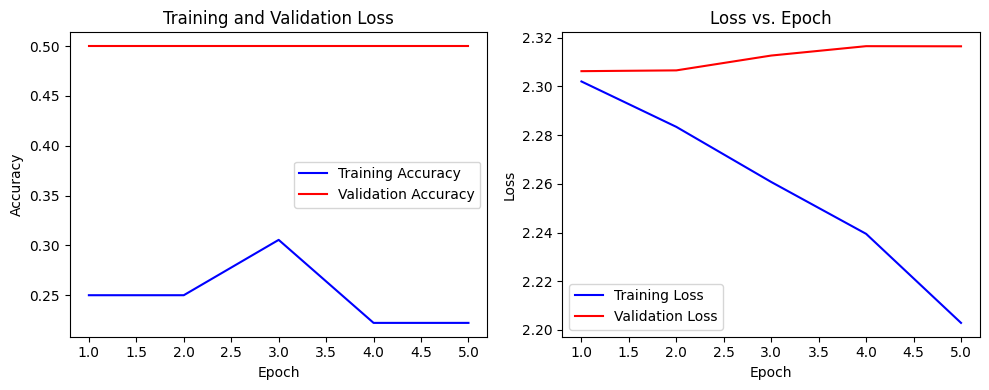

In [42]:
def show_accu_loss_graph(epoch, model):
    list_of_epochs = list(range(1, epoch+1))
    list_of_loss = model.history['loss']
    list_of_val_loss = model.history['val_loss']
    list_of_accuracy = model.history['accuracy']
    list_of_val_accuracy = model.history['val_accuracy']

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_accuracy, label='Training Accuracy', color='blue')
    plt.plot(list_of_epochs, list_of_val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_loss, label='Training Loss', color='blue')
    plt.plot(list_of_epochs, list_of_val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


show_accu_loss_graph(EPOCH, model_history)

__Evaluating Model:__ Determine the accuracy and the loss metrics for the test dataset

In [43]:
loss_score, accuracy_score = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_score}")
print(f"Test Loss: {loss_score}")

8/8 [==============================] - 8s 947ms/step - loss: 2.2572 - accuracy: 0.2407
Test Accuracy: 0.24066390097141266
Test Loss: 2.257185220718384


__Model Prediction:__ The prediction comprises the ten activations or probabilities associated with the output neurons corresponding to ratings 1-2. Get the highest probabilities as the final prediction.

In [44]:
y_prob = model.predict(X_test)      # probabilities of the prediction
y_pred=np.argmax(y_prob, axis=1)    # max probability for final prediction

# Increase the ratings by 1, as they were initially decreased by 1 due to the classification 
# problem starting with a value of 0
y_test_1 = y_test + 1
y_pred_1 = y_pred + 1

print(classification_report(y_test_1, y_pred_1))

8/8 [==============================] - 9s 907ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        60
           9       0.00      0.00      0.00        22
          10       0.24      1.00      0.39        58

    accuracy                           0.24       241
   macro avg       0.02      0.10      0.04       241
weighted avg       0.06      0.24      0.09       241



Text(50.722222222222214, 0.5, 'Predicted Class')

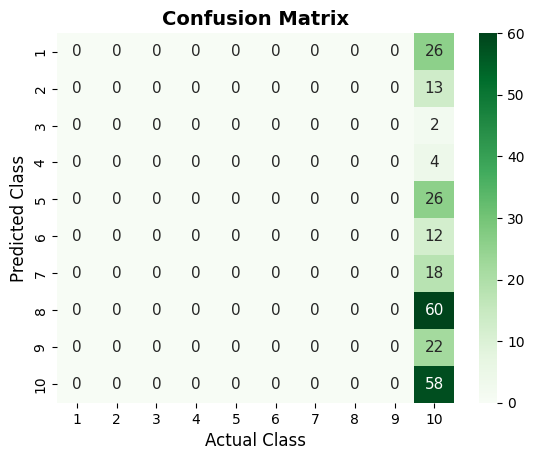

In [45]:
# Create a confusion matrix
class_labels = np.unique(y_test_1)
cm = confusion_matrix(y_test_1, y_pred_1)
cm_matrix = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)

sb.heatmap(cm_matrix, cmap='Greens', annot=True, fmt='d', annot_kws={"size": 11})

plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Actual Class', fontsize=12)
plt.ylabel('Predicted Class', fontsize=12)

## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/
- https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#google_vignette
- https://atilaycemsamiloglu.medium.com/what-is-lemmatization-2d7a87f42c55
- https://support.prodi.gy/t/how-to-tell-spacy-not-to-split-any-intra-hyphen-words/1456
- https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8
- https://python.plainenglish.io/optimize-your-spacy-ner-results-with-this-simple-change-e59937c411ab
- https://medium.com/@pi19404/using-pre-trained-word-vector-embeddings-for-sequence-classification-using-lstm-277dee188348
- https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15#:~:text=Default%20value%20%3D%2032&text=This%20is%20because%20the%20batch,%2C%20256%2C%20512%20and%201024!
- https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145

## Group 3 Members
- Abhishek Natani
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit 
- Rochan Mehta
- Roger Mais
- Varun Sharma 